Functions

In [69]:
import pandas as pd
import numpy as np
import umap
import numpy as np
import sklearn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap.plot
import GEOparse
from sklearn.decomposition import PCA
import plotly.graph_objs as go

import warnings
warnings.filterwarnings("ignore")

In [193]:
######################################################
def pca_analysis(df, n_comp=None):
    #1. Calculate PCA Dataframe and Agg statistics
    pca_df = df.copy()
    pca_df = pca_df.dropna().reset_index(drop=True)

    #create data object based on full df
    data_df = pca_df.drop(['cell_id', 'zone'], axis=1).copy()    
    data_df = data_df.astype(float)
    cols    = data_df.columns
    x       = data_df.loc[:, ].values #make sure only data columns are being passed

    #normalizes data to z scores
    x = StandardScaler().fit_transform(x)
    scaled_df = pd.DataFrame(data = x, columns = cols)

    pca = PCA(n_components = n_comp)
    principalComponents = pca.fit_transform(x) #Xnew

    # print(f'check variance with pca.explained_variance: \n{np.cov(principalComponents.T)}')
    print(f'pca.explained_variance: \t{pca.explained_variance_}')
    print(f'pca.explained_variance_ratio: \t{pca.explained_variance_ratio_}')

    #adjust pc_cols
    pc_cols = ['PC' + str(f+1) for f in range(n_comp)]
    # print(pc_cols)
    
    #creates dataframe from pca results
    principalDf = pd.DataFrame(data = principalComponents
                , columns = pc_cols)

    #df of pca analysis and potential clustering categories
    finalDf = pd.concat([principalDf, df[['cell_id', 'zone']]], axis = 1) # add additional cluster categories here
    
    return finalDf
######################################################
def plot_pca(df, n_comp=None):
    pca_df = df.copy()
    if n_comp == 3:
        ## Basic Plot ##
        # create a 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])

        # add labels to the plot
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
            # show the plot
        plt.show()

        # create a plotly figure
        fig = go.Figure()

        # add a 3D scatter plot
        fig.add_trace(go.Scatter3d(
            x=pca_df['PC1'], y=pca_df['PC2'], z=pca_df['PC3'],
            mode='markers',
            marker=dict(
                size=5,
                color=pca_df['PC3'],
                colorscale='Viridis',
                opacity=0.8
            )
        ))

        # add axes labels and title
        fig.update_layout(
            scene=dict(
                xaxis_title='PC1',
                yaxis_title='PC2',
                zaxis_title='PC3',
                aspectmode='cube',
            ),
            title='3D PCA Plot'
        )

        # show the figure
        fig.show()
    elif n_comp == 2: 
        # create 2 d scatter plot of pca
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='zone')
        plt.show()
######################################################
def load_rnaseq():
    # load table B
    rnaseq = pd.read_csv("./table_B_scRNAseq_UMI_counts.tsv", sep='\t')
    #sort top ~7531 genes
    rnaseq['total'] = rnaseq.sum(axis=1)

    rnaseq = rnaseq[rnaseq['total'] > 80].reset_index(drop=True) 
    # approximates the top genes from the paper, 
    # potentially need to review STAR methods and adjust how this is done
    rnaseq = rnaseq.reset_index(drop=True).set_index('gene')
    rnaseq = rnaseq.drop(columns='total') #UMI is number of observed transcripts
    rnaseq = rnaseq.transpose().reset_index().rename({'index':'cell_id'}, axis=1)

    #add location data based on cells
    loc_df = pd.read_csv("./table_C_scRNAseq_tsne_coordinates_zones.tsv", sep='\t')

    rnaseq = pd.merge(rnaseq, loc_df[['cell_id', 'zone']], on='cell_id')
    rnaseq
    return rnaseq
######################################################
def apply_umap(df=None):
    rnaseq = load_rnaseq()

    data_df = rnaseq.drop(['cell_id', 'zone'], axis=1).reset_index(drop=True)
    data_df = data_df.astype(float)

    #build model
    reducer = umap.UMAP()
    scaler  = sklearn.preprocessing.StandardScaler()
    data    = scaler.fit_transform(data_df)

    #UMAP
    embedding        = reducer.fit(data)
    rnaseq_coord_df  = pd.DataFrame(embedding.embedding_, columns=['X','Y'])

    #create projeciton with location data
    umap.plot.points(embedding, labels=rnaseq['zone'])
    plt.title(f'UMAP of Top {rnaseq.shape[1]} Genes Colored by Location Data')
    plt.show()
    return rnaseq_coord_df
######################################################

# Step 1: Recreate Previous Work

### PCA 2 Components

pca.explained_variance: 	[1053.61490409  267.88465929]
pca.explained_variance_ratio: 	[0.14008157 0.03561615]


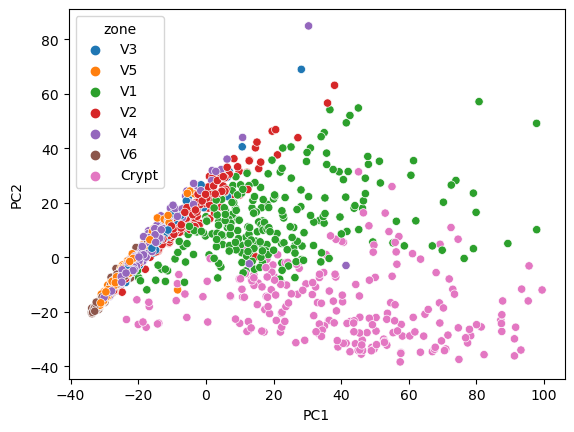

In [194]:
#table b
n_comp  = 2
rnaseq = load_rnaseq()

finalDf = pca_analysis(rnaseq, n_comp=n_comp)
finalDf = finalDf[finalDf['PC1'] < 100].reset_index(drop=True) #removal of outliers?
plot_pca(finalDf, n_comp=n_comp)

# fdoes data need to be log transformed? 

PCA 3 Components

pca.explained_variance: 	[1053.61490409  267.88465929  102.00179967]
pca.explained_variance_ratio: 	[0.14008157 0.03561615 0.01356147]


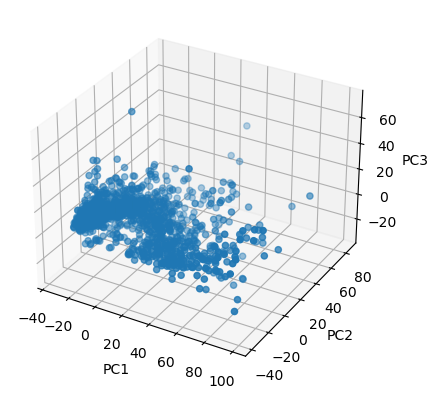

In [190]:
#table b
n_comp  = 3
rnaseq = load_rnaseq()

finalDf = pca_analysis(rnaseq, n_comp=n_comp)
finalDf = finalDf[finalDf['PC1'] < 100].reset_index(drop=True) #removal of outliers
plot_pca(finalDf, n_comp=n_comp)

Format Data and Apply ParTI.m Program

In [78]:
# need to transpose CSC_raw_seurat_data
# edit exampleCancer.m to use this and CSC_genes file



tSNE

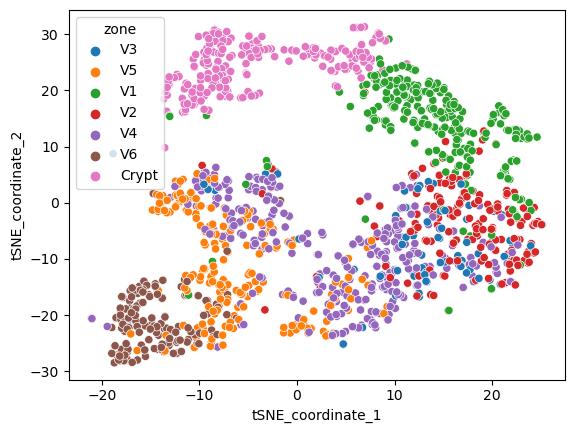

In [195]:
import seaborn as sns
tsne_df = pd.read_csv('./table_C_scRNAseq_tsne_coordinates_zones.tsv', sep='\t')

sns.scatterplot(data=tsne_df, x='tSNE_coordinate_1', y='tSNE_coordinate_2', hue='zone')

plt.show()

#needs more elegant plot, with "zone" column added as color hue
#What other filters could be interesting for this?? 

# Step 2: Apply UMAP and compare to previous Results

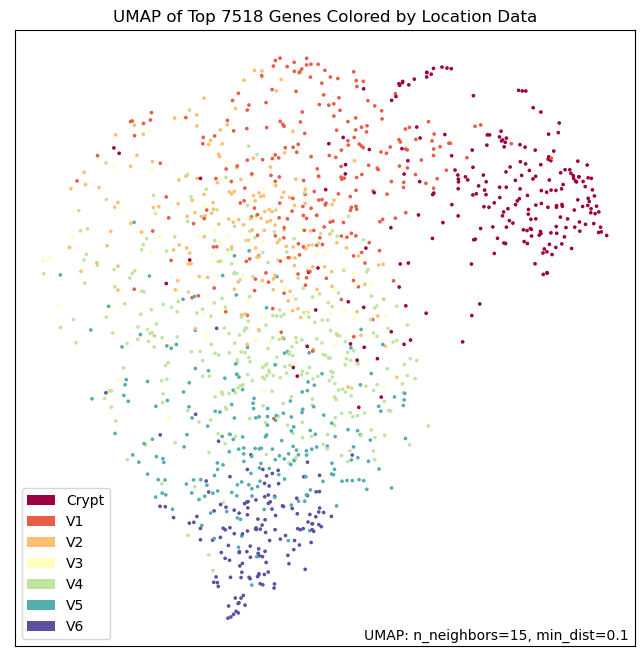

In [196]:
umap_coordinates = apply_umap()

In [192]:
umap_coordinates

,X,Y
0,-3.051582,10.174530
1,-4.464162,12.316375
2,-2.883590,8.638801
3,-4.712514,8.727706
4,-1.556396,8.885660
...,...,...
1378,-2.706063,8.159074
1379,-5.231598,11.625096
1380,-5.353289,11.044875
1381,-4.781877,10.423735


# Step 3: (If time) Apply to a different dataset, apply ParetoTI to UMAP results 

In [ ]:
import GEOparse
gse = GEOparse.get_GEO(geo="GDS4382", destdir='./new_data/')


In [13]:
df_gse = gse.table

non_control = df_gse[df_gse['IDENTIFIER'] != '--Control']
#determine overlap of genes with previous dataset


In [ ]:

import pandas as pd
data = pd.DataFrame(gse.table['VALUE'].T, index=gse.table['ID_REF'], columns=gse.table.columns[2:])
data
# df_geo = gse.table
# display(df_geo)